In [38]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = '' #'true'

#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
def sigmoid_squeeze(x):
    x = 1/(1+K.exp(-3*x))
    return x  


In [2]:
def make_batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]    

In [42]:
tf.math.softmax(tf.constant([1.,2.,3.]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.09003057, 0.24472848, 0.66524094], dtype=float32)>

In [55]:
class DHDT(tf.Module):
    
    def __init__(
            self,
            depth=3,
            function_representation_type = 3,
            number_of_variables = 5,
            learning_rate=1e-3,
            loss='binary_crossentropy',#'mae',
            random_seed=42,
            verbosity=1):    
        
        
        self.depth = depth
        self.learning_rate = learning_rate
        self.loss = tf.keras.losses.get(loss)
        self.seed = random_seed
        self.verbosity = verbosity
        self.function_representation_type = function_representation_type
        self.number_of_variables = number_of_variables
        
        self.internal_node_num_ = 2 ** self.depth - 1 
        self.leaf_node_num_ = 2 ** self.depth
        
        tf.random.set_seed(self.seed)
        
        function_representation_length = ( 
          (2 ** self.depth - 1) * 2 + (2 ** self.depth)  if self.function_representation_type == 1 
          else (2 ** self.depth - 1) + ((2 ** self.depth - 1) * self.number_of_variables) + (2 ** self.depth) if self.function_representation_type == 2 
          else ((2 ** self.depth - 1) * self.number_of_variables * 2) + (2 ** self.depth)  if self.function_representation_type >= 3 
          else None
                                      )        
        
        self.dt_params =  tf.Variable(tf.keras.initializers.GlorotUniform(seed=self.seed)(shape=(function_representation_length,)),
                                      trainable=True,
                                      name='dt_params')
        
    def fit(self, X, y, batch_size=32, epochs=100, early_stopping_epochs=5):
        
        minimum_loss_epoch = np.inf
        epochs_without_improvement = 0        
        
        for current_epoch in tqdm(range(epochs)):
            tf.random.set_seed(self.seed + current_epoch)
            X = tf.random.shuffle(X, seed=self.seed + current_epoch)
            tf.random.set_seed(self.seed + current_epoch)
            y = tf.random.shuffle(y, seed=self.seed + current_epoch)
            
            loss_list = []
            for index, (X_batch, y_batch) in enumerate(zip(make_batch(X, batch_size), make_batch(y, batch_size))):
                current_loss = self.backward(X_batch, y_batch)
                loss_list.append(float(current_loss))
                
                if self.verbosity >= 2:
                    batch_idx = (index+1)*batch_size
                    msg = "Epoch: {:02d} | Batch: {:03d} | Loss: {:.5f} |"
                    print(msg.format(current_epoch, batch_idx, current_loss))                   
                  
            if self.verbosity > 0:    
                msg = "Epoch: {:02d} | Loss: {:.5f} |"
                print(msg.format(current_epoch, np.mean(loss_list)))              
            
            current_loss_epoch = np.mean(loss_list)

            if current_loss_epoch < minimum_loss_epoch:
                minimum_loss_epoch = current_loss_epoch
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                
            if epochs_without_improvement >= early_stopping_epochs:
                break
    
    
    
    @tf.function(jit_compile=True)                    
    def forward(self, X):
        X = tf.dtypes.cast(tf.convert_to_tensor(X), tf.float32)       

        maximum_depth = self.depth
        leaf_node_num_ = 2 ** maximum_depth
        internal_node_num_ = 2 ** maximum_depth - 1
        
        dt_params_activation = self.apply_activation(self.dt_params)
        
        internal_nodes, leaf_nodes = self.get_shaped_parameters_for_decision_tree(dt_params_activation)

        function_values_dhdt = tf.vectorized_map(self.calculate_function_value_from_vanilla_decision_tree_parameter_single_sample_wrapper(internal_nodes,
                                                                                                                                          leaf_nodes,
                                                                                                                                          leaf_node_num_, 
                                                                                                                                          internal_node_num_, 
                                                                                                                                          maximum_depth,
                                                                                                                                          self.number_of_variables), 
                                                                                                                                          X)

        return function_values_dhdt  
           
    def predict(self, X):
        return self.forward(X)
        
    def backward(self, x,y):
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)#tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.01)
        with tf.GradientTape() as tape:
            #tape.watch(self.dt_params)
            predicted = self.forward(x)
            current_loss = self.loss(y, predicted)
            
        #tf.print('current_loss', current_loss, summarize=-1)
        #tf.print('self.dt_params', self.dt_params, summarize=-1)
        grads = tape.gradient(current_loss, self.dt_params)
        #optimizer.apply_gradients(zip(grads, self.dt_params),
        #                          global_step=tf.compat.v1.train.get_or_create_global_step())     
        
        #tf.print('grads', grads, summarize=-1)
        optimizer.apply_gradients(zip([grads], [self.dt_params]))
        #tf.print('self.dt_params', self.dt_params, summarize=-1)
        return current_loss
        
    
    def apply_activation(self, dt_params):

        dt_params_activation = dt_params
        
        if self.function_representation_type == 1:
            pass
        elif self.function_representation_type == 2:
            pass
        elif self.function_representation_type >= 3:
            outputs_coeff_neurons_num_ = self.internal_node_num_ * self.number_of_variables

            if self.function_representation_type == 3:
                dt_params_activation[:outputs_coeff_neurons_num_].assign(tf.math.sigmoid(dt_params[:outputs_coeff_neurons_num_]))
            elif self.function_representation_type == 4:
                dt_params_activation[:outputs_coeff_neurons_num_].assign(sigmoid_squeeze(dt_params[:outputs_coeff_neurons_num_]))

            current_position = outputs_coeff_neurons_num_
            for outputs_index in range(self.internal_node_num_):
                outputs_identifer_neurons = self.number_of_variables

                dt_params_activation[current_position:current_position+outputs_identifer_neurons].assign(tf.math.softmax(dt_params[current_position:current_position+outputs_identifer_neurons]))
                current_position += outputs_identifer_neurons

            dt_params_activation[current_position:].assign(tf.math.sigmoid(dt_params[current_position:]))

        
        return dt_params_activation
    
    def get_shaped_parameters_for_decision_tree(self, parameter_array):

        internal_node_num_ = 2 ** self.depth - 1 
        leaf_node_num_ = 2 ** self.depth

        if self.function_representation_type == 1:

            splits_coeff = parameter_array[:internal_node_num_]
            splits_coeff = tf.clip_by_value(splits_coeff, clip_value_min=0, clip_value_max=1)
            splits_coeff_list = tf.split(splits_coeff, internal_node_num_)
            splits_index = tf.cast(tf.clip_by_value(tf.round(parameter_array[internal_node_num_:internal_node_num_*2]), clip_value_min=0, clip_value_max=self.number_of_variables-1), tf.int64)
            splits_index_list = tf.split(splits_index, internal_node_num_)

            splits_list = []
            for values_node, indices_node in zip(splits_coeff_list, splits_index_list):
                sparse_tensor = tf.sparse.SparseTensor(indices=tf.expand_dims(indices_node, axis=1), values=values_node, dense_shape=[self.number_of_variables])
                dense_tensor = tf.sparse.to_dense(sparse_tensor)
                splits_list.append(dense_tensor)             

            splits = tf.stack(splits_list)            

            leaf_classes = parameter_array[internal_node_num_*2:]  
            leaf_classes = tf.clip_by_value(leaf_classes, clip_value_min=0, clip_value_max=1)

        elif self.function_representation_type == 2:

            split_values_num_params = internal_node_num_ 
            split_index_num_params = self.number_of_variables * internal_node_num_
            leaf_classes_num_params = leaf_node_num_ 

            split_values = parameter_array[:split_values_num_params]
            split_values_list_by_internal_node = tf.split(split_values, internal_node_num_)

            split_index_array = parameter_array[split_values_num_params:split_values_num_params+split_index_num_params]    
            split_index_list_by_internal_node = tf.split(split_index_array, internal_node_num_)
            split_index_list_by_internal_node_by_decision_sparsity = []
            for tensor in split_index_list_by_internal_node:
                split_tensor = tf.split(tensor, 1)
                split_index_list_by_internal_node_by_decision_sparsity.append(split_tensor)
            split_index_list_by_internal_node_by_decision_sparsity_argmax = tf.split(tf.argmax(split_index_list_by_internal_node_by_decision_sparsity, axis=2), internal_node_num_)
            split_index_list_by_internal_node_by_decision_sparsity_argmax_new = []
            for tensor in split_index_list_by_internal_node_by_decision_sparsity_argmax:
                tensor_squeeze = tf.squeeze(tensor, axis=0)
                split_index_list_by_internal_node_by_decision_sparsity_argmax_new.append(tensor_squeeze)
            split_index_list_by_internal_node_by_decision_sparsity_argmax = split_index_list_by_internal_node_by_decision_sparsity_argmax_new    
            dense_tensor_list = []
            for indices_node, values_node in zip(split_index_list_by_internal_node_by_decision_sparsity_argmax,  split_values_list_by_internal_node):
                sparse_tensor = tf.sparse.SparseTensor(indices=tf.expand_dims(indices_node, axis=1), values=values_node, dense_shape=[self.number_of_variables])
                dense_tensor = tf.sparse.to_dense(sparse_tensor)
                dense_tensor_list.append(dense_tensor) 
            splits = tf.stack(dense_tensor_list)

            leaf_classes_array = parameter_array[split_values_num_params+split_index_num_params:]  
            split_index_list_by_leaf_node = tf.split(leaf_classes_array, leaf_node_num_)

            leaf_classes = tf.squeeze(tf.stack(split_index_list_by_leaf_node))

        elif self.function_representation_type >= 3:

            split_values_num_params = self.number_of_variables * internal_node_num_
            split_index_num_params = self.number_of_variables * internal_node_num_
            leaf_classes_num_params = leaf_node_num_ 

            split_values = parameter_array[:split_values_num_params]
            split_values_list_by_internal_node = tf.split(split_values, internal_node_num_)

            split_index_array = parameter_array[split_values_num_params:split_values_num_params+split_index_num_params]    
            split_index_list_by_internal_node = tf.split(split_index_array, internal_node_num_)         

            split_index_list_by_internal_node_max = tfa.seq2seq.hardmax(split_index_list_by_internal_node)

            splits = tf.stack(tf.multiply(split_values_list_by_internal_node, split_index_list_by_internal_node_max))

            leaf_classes_array = parameter_array[split_values_num_params+split_index_num_params:]  
            split_index_list_by_leaf_node = tf.split(leaf_classes_array, leaf_node_num_)

            leaf_classes = tf.squeeze(tf.stack(split_index_list_by_leaf_node))



        return splits, leaf_classes


    def calculate_function_value_from_vanilla_decision_tree_parameter_single_sample_wrapper(self, 
                                                                                            internal_nodes, 
                                                                                            leaf_nodes, 
                                                                                            leaf_node_num_, 
                                                                                            internal_node_num_, 
                                                                                            maximum_depth, 
                                                                                            number_of_variables):

        #self.internal_nodes = tf.cast(self.internal_nodes, tf.float32)
        #self.leaf_nodes = tf.cast(self.leaf_nodes, tf.float32)   

        def calculate_function_value_from_vanilla_decision_tree_parameter_single_sample(x):

            x = tf.cast(x, tf.float32)

            internal_nodes_split = tf.split(internal_nodes, internal_node_num_)
            internal_nodes_split_new = [[] for _ in range(maximum_depth)]
            for i, tensor in enumerate(internal_nodes_split):
                current_depth = np.ceil(np.log2((i+1)+1)).astype(np.int32)

                internal_nodes_split_new[current_depth-1].append(tf.squeeze(tensor, axis=0))

            internal_nodes_split = internal_nodes_split_new

            split_value_list = []
            for i in range(maximum_depth):
                current_depth = i+1
                num_nodes_current_layer = 2**current_depth - 1 - (2**(current_depth-1) - 1)
                split_value_list_per_depth = []
                for j in range(num_nodes_current_layer):
                    zero_identifier = tf.not_equal(internal_nodes_split[i][j], tf.zeros_like(internal_nodes_split[i][j]))
                    split_complete = tf.greater(x, internal_nodes_split[i][j])
                    split_value = tf.reduce_any(tf.logical_and(zero_identifier, split_complete))
                    split_value_filled = tf.fill( [2**(maximum_depth-current_depth)] , split_value)
                    split_value_neg_filled = tf.fill([2**(maximum_depth-current_depth)], tf.logical_not(split_value))
                    split_value_list_per_depth.append(tf.keras.backend.flatten(tf.stack([split_value_neg_filled, split_value_filled])))        
                split_value_list.append(tf.keras.backend.flatten(tf.stack(split_value_list_per_depth)))

            split_values = tf.cast(tf.reduce_all(tf.stack(split_value_list), axis=0), tf.float32)    
            leaf_classes = tf.cast(leaf_nodes, tf.float32)
            final_class_probability = 1-tf.reduce_max(tf.multiply(leaf_classes, split_values))                                                                                                                                            
            return final_class_probability

        return calculate_function_value_from_vanilla_decision_tree_parameter_single_sample


    def plot(self, path='./dt_plot.png'):
        from anytree import Node, RenderTree
        from anytree.exporter import DotExporter
        
        normalizer_list = None#self.normalizer_list

        parameter_array = apply_activation(self, self.dt_params)
        
        splits, leaf_classes = self.get_shaped_parameters_for_decision_tree(parameter_array)

        splits = splits.numpy()
        leaf_classes = leaf_classes.numpy()


        if normalizer_list is not None: 
            transpose = splits.transpose()
            transpose_normalized = []
            for i, column in enumerate(transpose):
                column_new = column
                if len(column_new[column_new != 0]) != 0:
                    column_new[column_new != 0] = normalizer_list[i].inverse_transform(column[column != 0].reshape(-1, 1)).ravel()
                #column_new = normalizer_list[i].inverse_transform(column.reshape(-1, 1)).ravel()
                transpose_normalized.append(column_new)
            splits = np.array(transpose_normalized).transpose()

        splits_by_layer = []
        for i in range(self.depth+1):
            start = 2**i - 1
            end = 2**(i+1) -1
            splits_by_layer.append(splits[start:end])

        nodes = {
        }
        #tree = Tree()
        for i, splits in enumerate(splits_by_layer):
            for j, split in enumerate(splits):
                if i == 0:
                    current_node_id = int(2**i - 1 + j)
                    name = 'n' + str(current_node_id)#'l' + str(i) + 'n' + str(j)
                    split_variable = np.argmax(np.abs(split))
                    split_value = np.round(split[split_variable], 3)
                    split_description = 'x' + str(split_variable) + ' <= '  + str(split_value)

                    nodes[name] = Node(name=name, display_name=split_description)

                    #tree.create_node(tag=split_description, identifier=name, data=None)            
                else:
                    current_node_id = int(2**i - 1 + j)
                    name = 'n' + str(current_node_id)#'l' + str(i) + 'n' + str(j)
                    parent_node_id = int(np.floor((current_node_id-1)/2))
                    parent_name = 'n' + str(parent_node_id)
                    split_variable = np.argmax(np.abs(split))
                    split_value = np.round(split[split_variable], 3)
                    split_description = 'x' + str(split_variable) + ' <= '  + str(split_value)

                    nodes[name] = Node(name=name, parent=nodes[parent_name], display_name=split_description)

                    #tree.create_node(tag=split_description, identifier=name, parent=parent_name, data=None)

        for j, leaf_class in enumerate(leaf_classes):
            i = self.depth
            current_node_id = int(2**i - 1 + j)
            name = 'n' + str(current_node_id)#'l' + str(i) + 'n' + str(j)
            parent_node_id = int(np.floor((current_node_id-1)/2))
            parent_name = 'n' + str(parent_node_id)
            #split_variable = np.argmax(np.abs(split))
            #split_value = np.round(split[split_variable], 3)
            split_description = str(np.round((1-leaf_class), 3))#'x' + str(split_variable) + ' <= '  + str(split_value)
            nodes[name] = Node(name=name, parent=nodes[parent_name], display_name=split_description)
            #tree.create_node(tag=split_description, identifier=name, parent=parent_name, data=None)        

            DotExporter(nodes['n0'], nodeattrfunc=lambda node: 'label="{}"'.format(node.display_name)).to_picture(path)


        return Image(path)#, nodes#nodes#tree        

        
    

In [56]:
model_dhdt = DHDT(
            depth=3,
            function_representation_type = 3,
            number_of_variables = 5,
            learning_rate=1e-3,
            loss='binary_crossentropy',#'binary_crossentropy',
            random_seed=42,
            verbosity=0)

model_dhdt.fit(X_train, y_train, batch_size=64, epochs=10_000, early_stopping_epochs=50)

y_test_model = model_dhdt.predict(X_test)
score_dhdt = accuracy_score(y_test, np.round(y_test_model))

print('Test Accuracy', score_dhdt)

  0%|          | 0/10000 [00:00<?, ?it/s]

70 70
70 70
70 70
Test Accuracy 0.5016666666666667


In [11]:
X, y = make_classification(
    n_samples=10_000, n_features=5, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 1000  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=10_000 - train_samples,
)

In [12]:
model_sklearn = DecisionTreeClassifier(max_depth=3)

model_sklearn.fit(X_train, y_train)

model_sklearn.score(X_test, y_test)

0.8864444444444445

In [13]:
model_dhdt = DHDT(
            depth=3,
            function_representation_type = 1,
            number_of_variables = 5,
            learning_rate=1e-3,
            loss='mae',#'binary_crossentropy',
            random_seed=42,
            verbosity=0)

model_dhdt.fit(X_train, y_train, batch_size=64, epochs=10_000, early_stopping_epochs=50)

y_test_model = model_dhdt.predict(X_test)
score_dhdt = accuracy_score(y_test, np.round(y_test_model))

print('Test Accuracy', score_dhdt)

  0%|          | 0/10000 [00:00<?, ?it/s]

Test Accuracy 0.49833333333333335


In [14]:
model_dhdt = DHDT(
            depth=3,
            function_representation_type = 2,
            number_of_variables = 5,
            learning_rate=1e-3,
            loss='mae',#'binary_crossentropy',
            random_seed=42,
            verbosity=0)

model_dhdt.fit(X_train, y_train, batch_size=64, epochs=10_000, early_stopping_epochs=50)

y_test_model = model_dhdt.predict(X_test)
score_dhdt = accuracy_score(y_test, np.round(y_test_model))

print('Test Accuracy', score_dhdt)

  0%|          | 0/10000 [00:00<?, ?it/s]

Test Accuracy 0.49833333333333335


In [15]:
model_dhdt = DHDT(
            depth=3,
            function_representation_type = 3,
            number_of_variables = 5,
            learning_rate=1e-3,
            loss='mae',#'binary_crossentropy',
            random_seed=42,
            verbosity=0)

model_dhdt.fit(X_train, y_train, batch_size=64, epochs=10_000, early_stopping_epochs=50)

y_test_model = model_dhdt.predict(X_test)
score_dhdt = accuracy_score(y_test, np.round(y_test_model))

print('Test Accuracy', score_dhdt)

  0%|          | 0/10000 [00:00<?, ?it/s]

Test Accuracy 0.7226666666666667


In [16]:
model_dhdt = DHDT(
            depth=3,
            function_representation_type = 3,
            number_of_variables = 5,
            learning_rate=1e-3,
            loss='binary_crossentropy',#'binary_crossentropy',
            random_seed=42,
            verbosity=0)

model_dhdt.fit(X_train, y_train, batch_size=64, epochs=10_000, early_stopping_epochs=50)

y_test_model = model_dhdt.predict(X_test)
score_dhdt = accuracy_score(y_test, np.round(y_test_model))

print('Test Accuracy', score_dhdt)

  0%|          | 0/10000 [00:00<?, ?it/s]

Test Accuracy 0.7226666666666667


In [28]:
model_dhdt = DHDT(
            depth=3,
            function_representation_type = 3,
            number_of_variables = 5,
            learning_rate=1e-3,
            loss='binary_crossentropy',#'binary_crossentropy',
            random_seed=42,
            verbosity=0)

model_dhdt.fit(X_train, y_train, batch_size=64, epochs=10_000, early_stopping_epochs=50)

y_test_model = model_dhdt.predict(X_test)
score_dhdt = accuracy_score(y_test, np.round(y_test_model))

print('Test Accuracy', score_dhdt)

  0%|          | 0/10000 [00:00<?, ?it/s]

Test Accuracy 0.7226666666666667


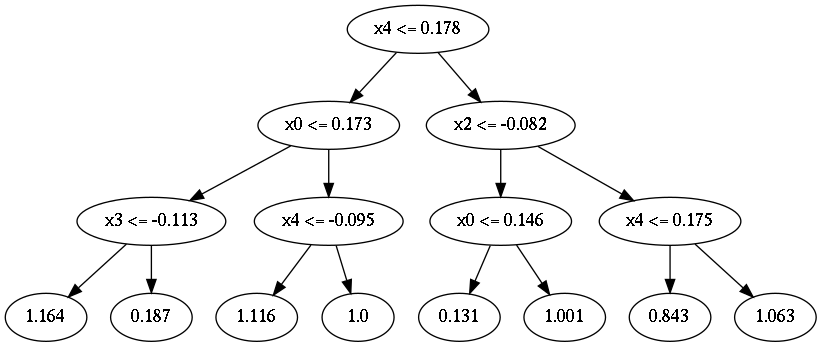

<Figure size 1080x576 with 0 Axes>

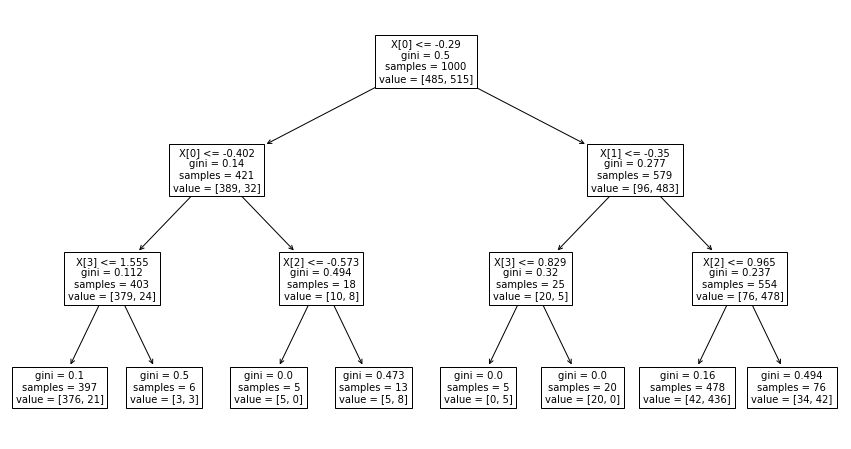

In [34]:
plt.figure(figsize=(15,8))
image = model_dhdt.plot()
display(image)

plt.figure(figsize=(15,8))
plot_tree(model_sklearn, fontsize=10) 
plt.show()

In [49]:
model_dhdt = DHDT(
            depth=3,
            function_representation_type = 3,
            number_of_variables = 5,
            learning_rate=1e-3,
            loss='binary_crossentropy',#'binary_crossentropy',
            random_seed=42,
            verbosity=0)

model_dhdt.fit(X_train, y_train, batch_size=64, epochs=10_000, early_stopping_epochs=50)

y_test_model = model_dhdt.predict(X_test)
score_dhdt = accuracy_score(y_test, np.round(y_test_model))

print('Test Accuracy', score_dhdt)

  0%|          | 0/10000 [00:00<?, ?it/s]

TypeError: in user code:

    File "/tmp/ipykernel_2414079/1710018781.py", line 84, in forward  *
        dt_params_activation = self.apply_activation(self.dt_params)
    File "/tmp/ipykernel_2414079/2163185584.py", line 130, in apply_activation  *
        dt_params[:outputs_coeff_neurons_num_] = tf.math.sigmoid(dt_params[:outputs_coeff_neurons_num_])

    TypeError: 'ResourceVariable' object does not support item assignment


In [ ]:
plt.figure(figsize=(15,8))
image = model_dhdt.plot()
display(image)

plt.figure(figsize=(15,8))
plot_tree(model_sklearn, fontsize=10) 
plt.show()